In [1]:
import os
import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.transform import warp, AffineTransform, rescale
from skimage.feature import canny
from skimage import color
from skimage.io import imread
from sklearn.cluster import KMeans

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
n_colors = 64
image_dir = '/Users/benjaminlucas/Projects/EarthPortrait/StopMotionAnimation/EarthImages_Color4'
image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.split('.')[1] == 'JPG']
image_files = sorted(image_files, key=lambda x: int(x.split('.')[0].split('_')[1]))
image_files = [image_dir + os.path.sep + f for f in image_files]

In [33]:
clip = mp.ImageSequenceClip(image_files, fps=15)
clip_small = clip.resize(0.1)
#clip_rotated = clip_small.fx(mp.vfx.rotate, 270)
(w, h) = clip_small.size
clip_cropped = clip_small.crop( x_center=w//2 , width=h)
clip_cropped.write_gif('earth_rotate.gif', program='ffmpeg')
os.system('gifsicle -O3 --colors ' + str(n_colors) + ' earth_rotate.gif > earth_rotate_opt.gif')

t:   6%|▋         | 2/31 [00:00<00:02, 12.33it/s, now=None]

MoviePy - Building file  earth_rotate.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: earth_rotate.gif.


0

In [31]:
(w, h) = clip_small.size
crop_w = int(0.8 * w)
clip_cropped = clip_small.crop( x_center=w//2 , width=h)

In [29]:
w

326

In [ ]:
## Frame by Frame Manipulation:

In [7]:
#Compress Color Space?
def CompressColor(im, compression_factor = 1.25):
    im = 255 * np.arctan(compression_factor * im / 255)
    im = im.astype(np.uint8)
    return im

In [8]:
def LocalColorCompression(im, model, compression = 0.7):
    dims = np.shape(im)
    im_mat = np.reshape(im, (-1, 3))
    cluster_inds = model.predict(im_mat)
    cluster_centers = model.cluster_centers_[cluster_inds]
    im_compressed = (1 - compression) * im_mat + compression*cluster_centers
    im_compressed = np.reshape(im_compressed, dims)
    return im_compressed.astype(np.uint8)


In [9]:
def CompressHSV(im, sat_comp = 0.7, value_comp = 0.7):
    im_hsv = color.rgb2hsv(im)
    im_hsv[:,:,1] = np.arctan(sat_comp * im_hsv[:,:,1])
    im_hsv[:,:,2] = value_comp * im_hsv[:,:,2]
    im_hsv = np.minimum(im_hsv,np.ones(np.shape(im_hsv)))
    im_rgb = 255 * color.hsv2rgb(im_hsv)
    return im_rgb.astype(np.uint8)

In [10]:
def ClusterColors(img_mat, n_colors):
    model = KMeans(n_clusters=n_colors)
    model.fit(img_mat)
    return model

In [11]:
images = []
for f in image_files:
    im = imread(f)
    images.append(im)

In [12]:
sample_pts = []
random_pts_per_im = 1000
for im in images:
    im_mat = np.reshape(im, (-1, 3))
    random_indices = np.random.choice(random_pts_per_im, size=2, replace=False)
    random_rows = im_mat[random_indices, :]
    sample_pts = np.vstack(sample_pts, random_rows)

#im = images[0]
#im_mat = np.reshape(im, (-1, 3))
model = ClusterColors(sample_pts, 8)
#im_compressed = LocalColorCompression(im, model, scaling = 0.8)

TypeError: _vhstack_dispatcher() takes 1 positional argument but 2 were given

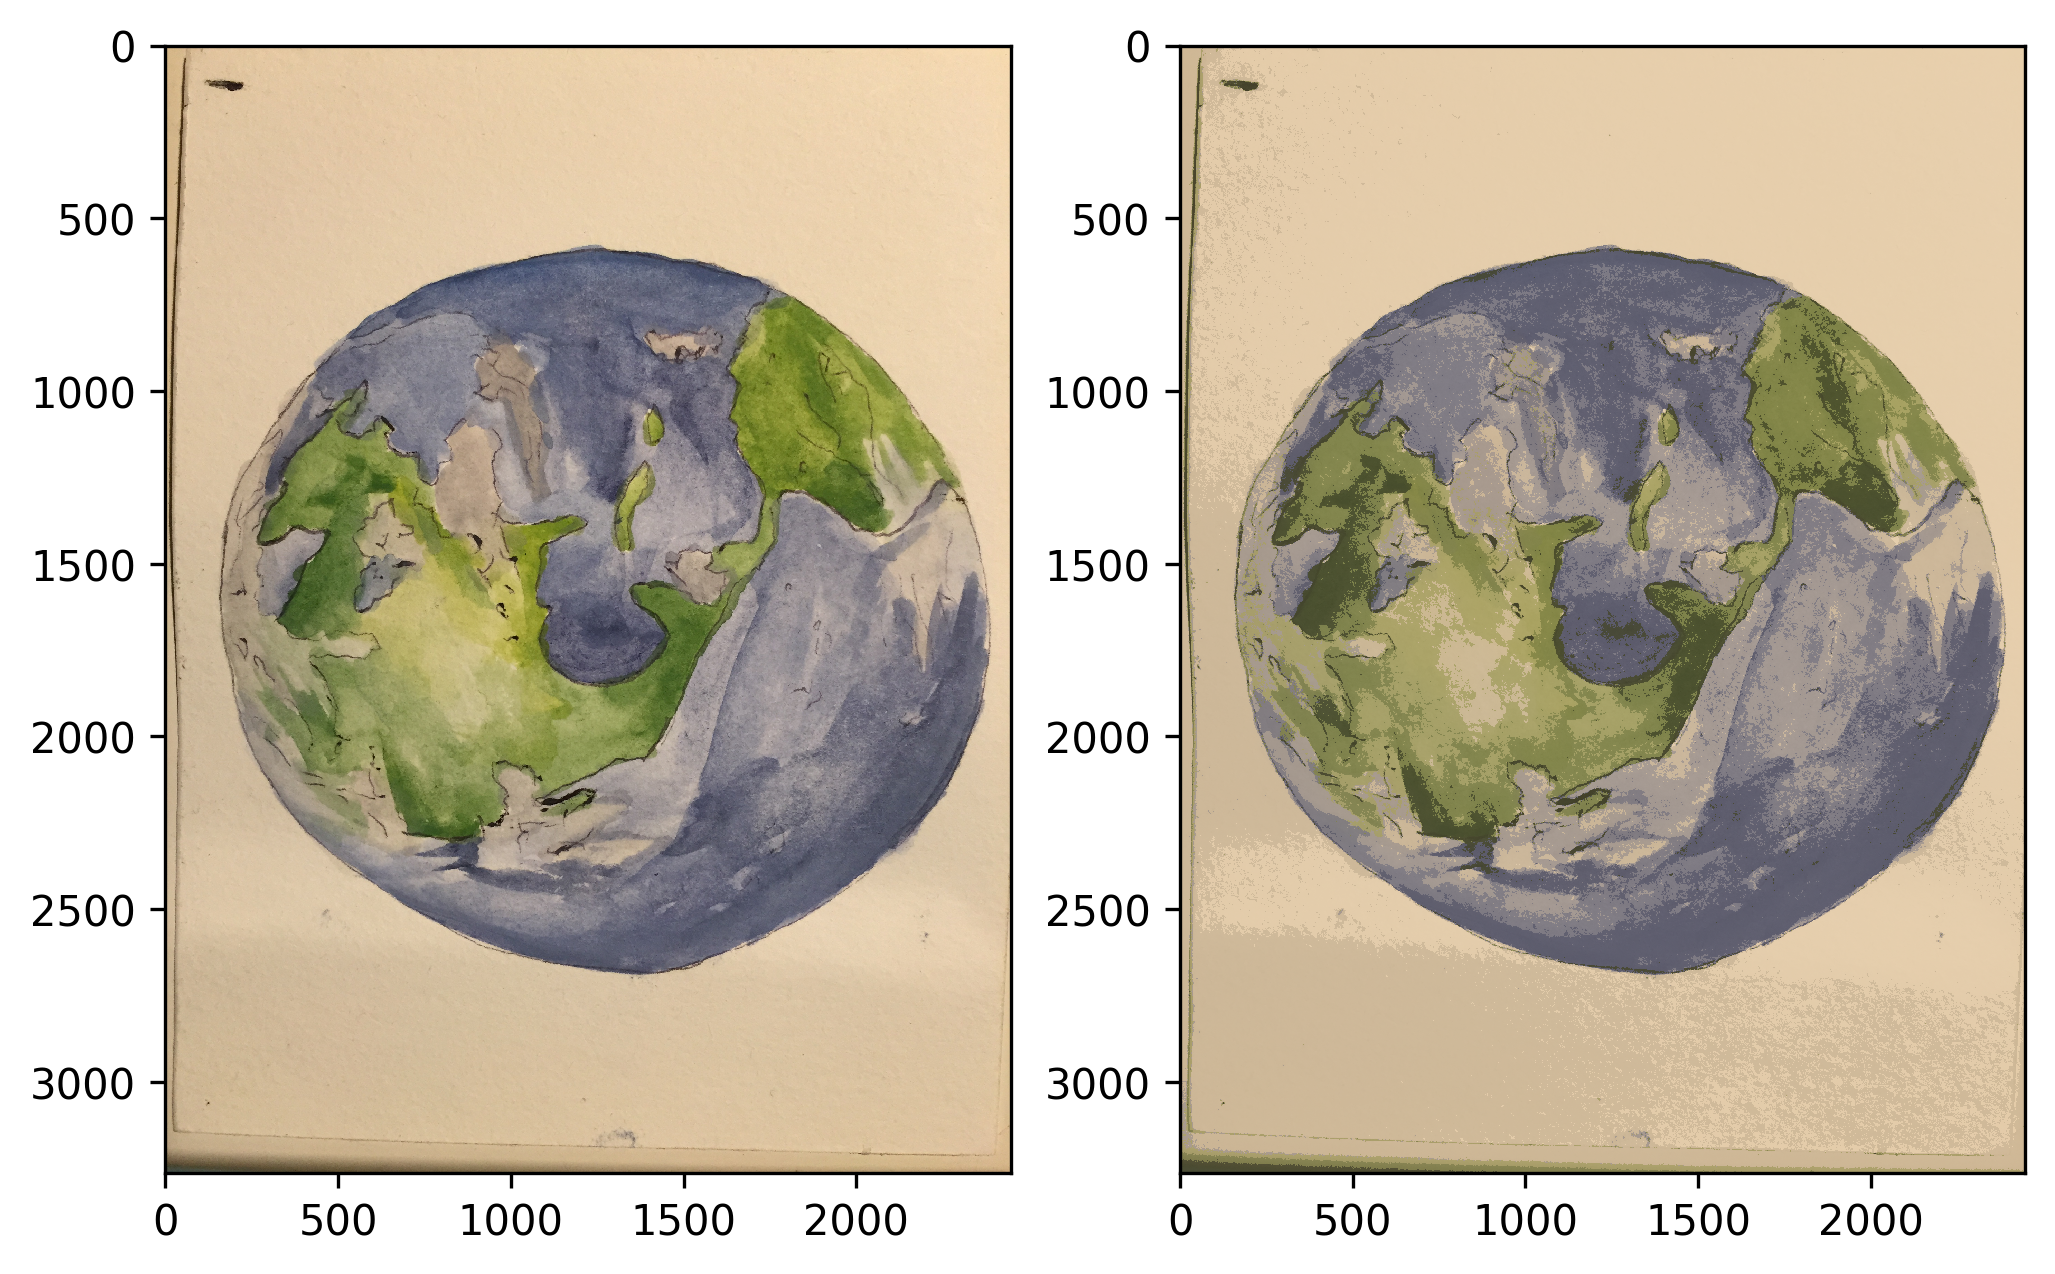

In [43]:
fig, ax = plt.subplots(1,2, figsize = (8,6), dpi = 300)
ax[0].imshow(im)
ax[1].imshow(im_compressed)



In [90]:
images_compressed = []
images_sat_compressed = []
for i in range(0,20,8):#range(len(images)):#
    im = images[i]
    images_compressed.append(CompressColor(im))
    images_sat_compressed.append(CompressSaturation(im))

In [91]:
clip = mp.ImageSequenceClip(images_compressed, fps=10)
clip_small = clip.resize(0.1)
clip_small.write_gif('earth_rotate_compressed.gif')
os.system('gifsicle -O3 --colors ' + str(n_colors) + ' earth_rotate_compressed.gif > earth_rotate_compressed_opt.gif')

t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]

MoviePy - Building file earth_rotate_compressed.gif with imageio.


0

In [53]:
im = images[10]
im = im[1000:2500, 500:2000,:]
#im = rescale(im, 0.2, anti_aliasing=True)

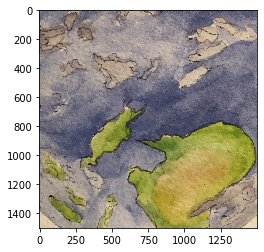

In [73]:
plt.imshow(im)

In [72]:
def WarpHSV(im, sat_comp = 2.0, value_comp = 0.8):
    im_hsv = color.rgb2hsv(im)
    im_hsv[:,:,1] = np.arctan(sat_comp * im_hsv[:,:,1])
    im_hsv[:,:,2] = value_comp * im_hsv[:,:,2]
    im_hsv = np.minimum(im_hsv,np.ones(np.shape(im_hsv)))
    im_rgb = 255 * color.hsv2rgb(im_hsv)
    return im_rgb.astype(np.uint8)

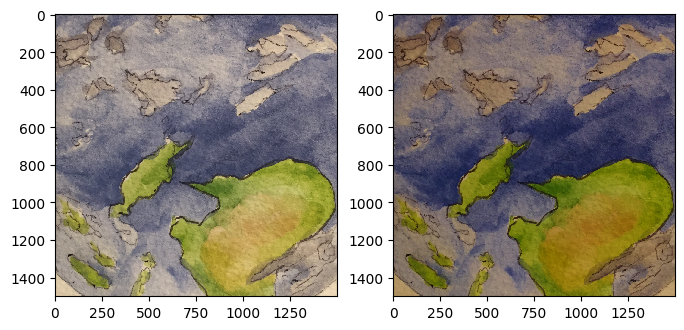

In [74]:

im_sat = WarpHSV(im, 2, 0.8)
fig, ax = plt.subplots(1,2, figsize=(8,6), dpi=100)
ax[0].imshow(im)
ax[1].imshow(im_sat)

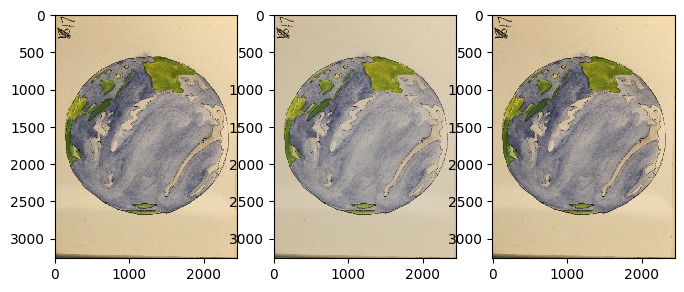

In [38]:
ind = 5
available_inds = list(range(0,20,8))
fig, ax = plt.subplots(1,3, figsize=(8, 6), dpi=100)
ax[0].imshow(images[available_inds[ind]])
ax[1].imshow(images_compressed[ind])
ax[2].imshow(images_sat_compressed[ind])

In [15]:
np.max(im)

199

In [25]:
im = images[0]
im_gray = rgb2gray(im)
edges = canny(im_gray, sigma=1)#, low_threshold=0.1, high_threshold=0.5)
imshow(edges)
plt.show()
# Detect two radii
hough_radii = np.arange(1100, 1300, 3)
hough_res = hough_circle(im_gray, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)



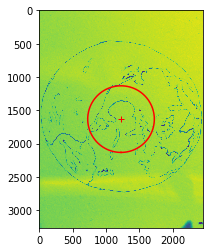

In [42]:
plt.imshow(im_gray)
plt.plot(cx, cy ,'r+')
theta = np.linspace(0,2*np.pi,100)
plt.plot([cx[0] + radii[0] * np.sin(th) for th in theta], [cy[0] + radii[0] * np.cos(th) for th in theta], 'r')
plt.show()

In [ ]:
translation = AffineTransform(scale=1, rotation=0, translation=(210, 50))
im_centered = warp(im, tform.inverse)


In [ ]:
tform = tf.SimilarityTransform(scale=1, rotation=math.pi/4,
                               translation=(text.shape[0]/2, -100))

rotated = tf.warp(text, tform)